In [1]:
# Install required packages (uncomment if not already installed)
# !pip install torch torchvision torchmetrics tqdm pandas matplotlib numpy

# Import required libraries
import os
import json
import argparse
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms_v2
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt

# Import your custom modules
from models.vae import VAE
from utils.dataset.nih import NIHChestDataset

# Set logging
import logging
logging.basicConfig(level=logging.INFO)

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

c:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [10]:
# pre processing
from utils.preprocessing.preprocessing_v2 import preprocess_dataset

# Define the correct paths
DATASET_PATH = "C:\Data/archive"  # data set path
SAVE_PATH = "C:\Data\processed"  # path to save processed data
IMAGE_DIM = 224

# Create an argparse Namespace to pass arguments
args = argparse.Namespace(
    dataset_path=DATASET_PATH,
    save_path=SAVE_PATH,
    image_dim=IMAGE_DIM
)

# Run the preprocessing function
preprocess_dataset(args)

print(f"Preprocessing completed! Processed dataset saved at: {SAVE_PATH}")

INFO:utils.preprocessing.preprocessing_v2:Processing 112120 images using 20 processes...
Processing Images: 100%|██████████| 112120/112120 [01:55<00:00, 966.58it/s]
INFO:utils.preprocessing.preprocessing_v2:Dataset saved with 47990 (Train), 5999 (Dev), 5999 (Test)


Preprocessing completed! Processed dataset saved at: C:\Data\processed


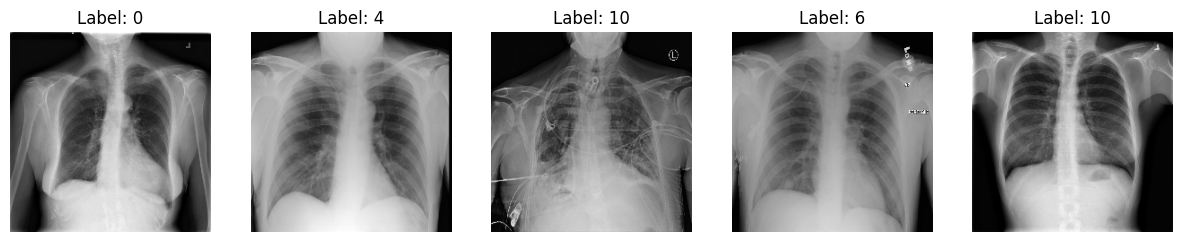

In [11]:
SAVE_PATH = "C:\Data\processed"  # path to save processed data
# Load the processed images and labels
train_images = np.load(SAVE_PATH + "/train_images.npy")
train_labels = np.load(SAVE_PATH + "/train_labels.npy")

# Visualize some images
num_samples = 5  # Number of images to display
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    axes[i].imshow(train_images[i].squeeze(), cmap='gray')  # Remove extra dimension if necessary
    axes[i].set_title(f"Label: {train_labels[i]}")
    axes[i].axis("off")

plt.show()

In [2]:
from train_vae import train_vae

SAVE_PATH = "C:\Data\processed"  # path of processed data

args = argparse.Namespace(
    train_images_path= SAVE_PATH + '/train_images.npy',
    dev_images_path=SAVE_PATH + '/dev_images.npy',
    train_labels_path=SAVE_PATH + '/train_labels.npy',
    dev_labels_path=SAVE_PATH + '/dev_labels.npy',
    save_path='model_outputs/vae',
    epochs=20,
    beta_weightage=1e-4,
    learning_rate=3e-4,
    batch_size=256,
    image_dim=224,
    num_workers=4,
    device='cuda'
)

train_vae(args)

Epoch: 1 / 20. Loss: 0.0214, PSNR: 20.5671 SSIM: 0.4247: 100%|██████████| 188/188 [01:27<00:00,  2.14it/s]
Epoch: 1 / 20. Loss: 0.0085, PSNR: 20.9756 SSIM: 0.6639: 100%|██████████| 24/24 [00:25<00:00,  1.04s/it]
INFO:root:Model Saved
Epoch: 2 / 20. Loss: 0.0073, PSNR: 22.3586 SSIM: 0.5134: 100%|██████████| 188/188 [01:04<00:00,  2.93it/s]
Epoch: 2 / 20. Loss: 0.0058, PSNR: 22.2701 SSIM: 0.6827: 100%|██████████| 24/24 [00:13<00:00,  1.74it/s]
INFO:root:Model Saved
Epoch: 3 / 20. Loss: 0.0055, PSNR: 23.3234 SSIM: 0.5615: 100%|██████████| 188/188 [01:04<00:00,  2.92it/s]
Epoch: 3 / 20. Loss: 0.0058, PSNR: 22.4528 SSIM: 0.6965: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]
INFO:root:Model Saved
Epoch: 4 / 20. Loss: 0.0048, PSNR: 23.7103 SSIM: 0.5781: 100%|██████████| 188/188 [01:04<00:00,  2.91it/s]
Epoch: 4 / 20. Loss: 0.0062, PSNR: 22.0721 SSIM: 0.6988: 100%|██████████| 24/24 [00:13<00:00,  1.73it/s]
INFO:root:Model Saved
Epoch: 5 / 20. Loss: 0.0044, PSNR: 23.8705 SSIM: 0.5891: 100%|██

In [7]:
from test_vae import test_vae

SAVE_PATH = "C:\Data\processed"  # path to save processed data

class Args:
    test_dataset_path = SAVE_PATH + "/test_images.npy"
    test_images_path = SAVE_PATH + "/test_images.npy"
    test_labels_path = SAVE_PATH + "/test_labels.npy"
    save_path = 'model_outputs/vae/test'
    model_weights = 'model_outputs/vae/model_weights/vae_weights_1.pth'
    beta_weightage = 1e-4
    batch_size = 256
    image_dim = 224
    num_workers = 4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mc_passes = 50

args = Args()
test_vae(args)

Loss: 0.0484, PSNR: 13.1765 SSIM: 0.5260: 100%|██████████| 4/4 [00:29<00:00,  7.38s/it]


In [ ]:
from test_vae import enable_dropout

model = VAE(IMAGE_DIM).to(DEVICE)
    
model.load_state_dict(torch.load('model_outputs/vae/model_weights/vae_weights_1.pth', weights_only=True))
    
noisy_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms_v2.GaussianNoise(),
        transforms.Normalize(0, 1)
])
    
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
])

test_images, test_labels = np.load("C:\Data\processed\test_images.npy"), np.load("C:\Data\processed\test_labels.npy")
test_dataset = NIHChestDataset(test_images, test_labels, transform, noisy_transform)

    # Prepare Dataloader
test_dataloader = DataLoader(test_dataset, 256, shuffle=True, num_workers=4, persistent_workers=True)
    
    # Progress Bar
test_progress_bar = tqdm(test_dataloader)
    
    # Metrics
psnr = PeakSignalNoiseRatio().to(DEVICE)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

    # Eval Model
test_total_loss = 0
model.eval()    
with torch.no_grad():
        for noisy_images, clean_images, _ in test_progress_bar:
            noisy_images, clean_images = noisy_images.to(DEVICE), clean_images.to(DEVICE)
            
            # Perform MC_PASSES forward passes with dropout enabled
            predictions = []
            for _ in range(10):
                enable_dropout(model)  # Re-enable dropout layers for this pass
                denoised_images, mean, log_variance = model(noisy_images)
                predictions.append(denoised_images.unsqueeze(0))
            
            # Aggregate predictions over MC_PASSES (compute the mean prediction)
            predictions = torch.cat(predictions, dim=0)  # shape: [MC_PASSES, batch, channels, H, W]
            mean_prediction = predictions.mean(dim=0)
            variance_prediction = np.var(predictions, axis=0)
            # Optionally, compute uncertainty:
            uncertainty = predictions.std(dim=0)
            
            # Compute loss and metrics using the mean prediction
            loss = model.loss_function(mean_prediction, clean_images, mean, log_variance, 1e-4)
            test_total_loss += loss.item()
            psnr_value = psnr(mean_prediction, clean_images).item()
            ssim_value = ssim(mean_prediction, clean_images).item()
            test_progress_bar.set_description(f"Loss: {test_total_loss/len(test_dataloader):.4f}, PSNR: {psnr_value:.4f} SSIM: {ssim_value:.4f}")